## DEVOIR 02:APPLICATION DES DIFFERENTES METHODES DE DISCRETISATION

In [27]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Charger le dataset Wine
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
print("Aperçu du dataset Wine:")
print(df.head(), "\n")

Aperçu du dataset Wine:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proli

In [12]:
# On choisit une variable continue à discrétiser, ex: "alcohol"
X = df[['alcohol']].values
y = df['target'].values

### Méthode basée sur la discrétisation

### Intervalles de largeur égales

#### Explication : ici,nous divisons la plage des valeurs en intervalles de meme longueur. Choississons k=3.Pour ce faire,nous allons calculer les bornes avec la formue suivante :Largeur=(max−min)/nombres d intervalles

#### k=3 est souvent utilisé si on sait qu’il y a environ 3 sous-groupes naturels dans la donnée (ici, le dataset Wine a 3 classes de vin).

#### Donc le choix de k=3 est cohérent avec le nombre de classes réelles (target) du dataset.

In [20]:

# Variable choisie
col = 'alcohol'
values = df[col].values

# Paramètres
k = 3  # nombre d'intervalles
vmin, vmax = values.min(), values.max()

# Formule
width = (vmax - vmin) / k
bins = [vmin + i*width for i in range(k)] + [vmax]  # bornes des intervalles

# Discrétisation
df['alcohol_equal_width'] = pd.cut(values, bins=bins, labels=False, include_lowest=True)

# Affichage
print(f"Valeur min = {vmin:.2f}, max = {vmax:.2f}")
print(f"Largeur d'intervalle = {width:.2f}")
print("\nBornes des intervalles :", [round(b, 2) for b in bins], "\n")

# Afficher chaque intervalle correctement
for i in range(len(bins) - 1):
    gauche = bins[i]
    droite = bins[i+1]
    if i < len(bins) - 2:
        print(f"Intervalle {i} : [{gauche:.2f}, {droite:.2f})")
    else:
        print(f"Intervalle {i} : [{gauche:.2f}, {droite:.2f}]")

print("\nAperçu (10 premières lignes):")
print(df[[col, 'alcohol_equal_width']].head(10))


Valeur min = 11.03, max = 14.83
Largeur d'intervalle = 1.27

Bornes des intervalles : [np.float64(11.03), np.float64(12.3), np.float64(13.56), np.float64(14.83)] 

Intervalle 0 : [11.03, 12.30)
Intervalle 1 : [12.30, 13.56)
Intervalle 2 : [13.56, 14.83]

Aperçu (10 premières lignes):
   alcohol  alcohol_equal_width
0    14.23                    2
1    13.20                    1
2    13.16                    1
3    14.37                    2
4    13.24                    1
5    14.20                    2
6    14.39                    2
7    14.06                    2
8    14.83                    2
9    13.86                    2


#### Problé"me:certains intervalles peuvent contenir très peu d’instances ou bien plus

### Fréquences égales

#### Explication: ici chaque intervalle contient environ le meme nombres d instances.Pour ce faire,appliquons la formule taille_intervalle=nombre d obserations/nombre d intervalles

In [21]:

# On choisit la variable 'alcohol'
X = df[['alcohol']]

# Discrétisation Equal Frequency
equal_freq = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['alcohol_equal_freq'] = equal_freq.fit_transform(X)

# Afficher les bornes
print("Bornes Equal Frequency:")
print(equal_freq.bin_edges_[0], "\n")

# Afficher proprement chaque intervalle
edges = equal_freq.bin_edges_[0]
for i in range(len(edges) - 1):
    gauche = edges[i]
    droite = edges[i+1]
    if i < len(edges) - 2:
        print(f"Intervalle {i} : [{gauche:.2f}, {droite:.2f})")
    else:
        print(f"Intervalle {i} : [{gauche:.2f}, {droite:.2f}]")


Bornes Equal Frequency:
[11.03 12.52 13.48 14.83] 

Intervalle 0 : [11.03, 12.52)
Intervalle 1 : [12.52, 13.48)
Intervalle 2 : [13.48, 14.83]


### Entropie 

#### Explication:ici,nous minimise l'entropie de classe dans chaque intervalle

In [22]:



# Variable choisie
X = df[['alcohol']].values.ravel()

# Définir nombre max de coupures (paramètre à ajuster)
k = 3

# Générer des seuils candidats (percentiles)
seuils = np.percentile(X, np.linspace(0, 100, k+1)[1:-1])

# Discrétiser selon ces seuils
df['alcohol_entropy_like'] = np.digitize(X, bins=seuils)

# Évaluer la pertinence des coupures par information mutuelle
mi = mutual_info_classif(df[['alcohol_entropy_like']], y, discrete_features=True)

print("Bornes 'entropy-like' (percentiles choisis):", seuils, "\n")
for i in range(len(seuils)+1):
    if i == 0:
        print(f"Intervalle {i} : (-inf, {seuils[i]:.2f})")
    elif i == len(seuils):
        print(f"Intervalle {i} : [{seuils[i-1]:.2f}, +inf)")
    else:
        print(f"Intervalle {i} : [{seuils[i-1]:.2f}, {seuils[i]:.2f})")

print("\nInformation mutuelle avec la cible:", mi[0])
print("\nAperçu (10 premières lignes):")
print(df[['alcohol', 'alcohol_entropy_like']].head(10))


Bornes 'entropy-like' (percentiles choisis): [12.52 13.48] 

Intervalle 0 : (-inf, 12.52)
Intervalle 1 : [12.52, 13.48)
Intervalle 2 : [13.48, +inf)

Information mutuelle avec la cible: 0.37789395784729063

Aperçu (10 premières lignes):
   alcohol  alcohol_entropy_like
0    14.23                     2
1    13.20                     1
2    13.16                     1
3    14.37                     2
4    13.24                     1
5    14.20                     2
6    14.39                     2
7    14.06                     2
8    14.83                     2
9    13.86                     2


### Methode basée sur le clustering 

#### Explication: On applique un algorithme de clustering sur les valeurs continues, puis on affecte chaque cluster à un intervalle.

#### Exemple : appliquer k-means sur la variable alcohol avec k=3 → 3 groupes naturels : faible, moyen, fort.

In [23]:
# On récupère la colonne alcohol comme array numpy
X = df['alcohol'].values.reshape(-1, 1)
# KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
clusters = kmeans.fit_predict(X)
df['alcohol_clusters'] = clusters

# Centres des clusters
centres = np.sort(kmeans.cluster_centers_.flatten())

print("Centres des clusters (KMeans):")
for i, c in enumerate(centres):
    print(f"Cluster {i} : centre = {c:.2f}")

# Déterminer les bornes des intervalles (à partir des centres triés)
# Les coupures sont à mi-chemin entre deux centres
bornes = []
for i in range(len(centres)-1):
    borne = (centres[i] + centres[i+1]) / 2
    bornes.append(borne)

print("\nBornes estimées entre clusters :", [round(b, 2) for b in bornes], "\n")

# Afficher les intervalles de chaque cluster
for i in range(len(centres)):
    if i == 0:
        print(f"Cluster {i} : (-inf, {bornes[i]:.2f})")
    elif i == len(centres)-1:
        print(f"Cluster {i} : [{bornes[i-1]:.2f}, +inf)")
    else:
        print(f"Cluster {i} : [{bornes[i-1]:.2f}, {bornes[i]:.2f})")

print("\nAperçu (10 premières lignes):")
print(df[['alcohol', 'alcohol_clusters']].head(10))


Centres des clusters (KMeans):
Cluster 0 : centre = 12.09
Cluster 1 : centre = 13.02
Cluster 2 : centre = 13.90

Bornes estimées entre clusters : [np.float64(12.55), np.float64(13.46)] 

Cluster 0 : (-inf, 12.55)
Cluster 1 : [12.55, 13.46)
Cluster 2 : [13.46, +inf)

Aperçu (10 premières lignes):
   alcohol  alcohol_clusters
0    14.23                 1
1    13.20                 2
2    13.16                 2
3    14.37                 1
4    13.24                 2
5    14.20                 1
6    14.39                 1
7    14.06                 1
8    14.83                 1
9    13.86                 1


### Conclusion

In [29]:
print("Aperçu des colonnes discrétisées:")
print(df[['alcohol', 'alcohol_equal_width', 'alcohol_equal_freq','alcohol_entropy_like', 'alcohol_clusters']].head(11))



Aperçu des colonnes discrétisées:
    alcohol  alcohol_equal_width  alcohol_equal_freq  alcohol_entropy_like  \
0     14.23                    2                 2.0                     2   
1     13.20                    1                 1.0                     1   
2     13.16                    1                 1.0                     1   
3     14.37                    2                 2.0                     2   
4     13.24                    1                 1.0                     1   
5     14.20                    2                 2.0                     2   
6     14.39                    2                 2.0                     2   
7     14.06                    2                 2.0                     2   
8     14.83                    2                 2.0                     2   
9     13.86                    2                 2.0                     2   
10    14.10                    2                 2.0                     2   

    alcohol_clusters  
0     

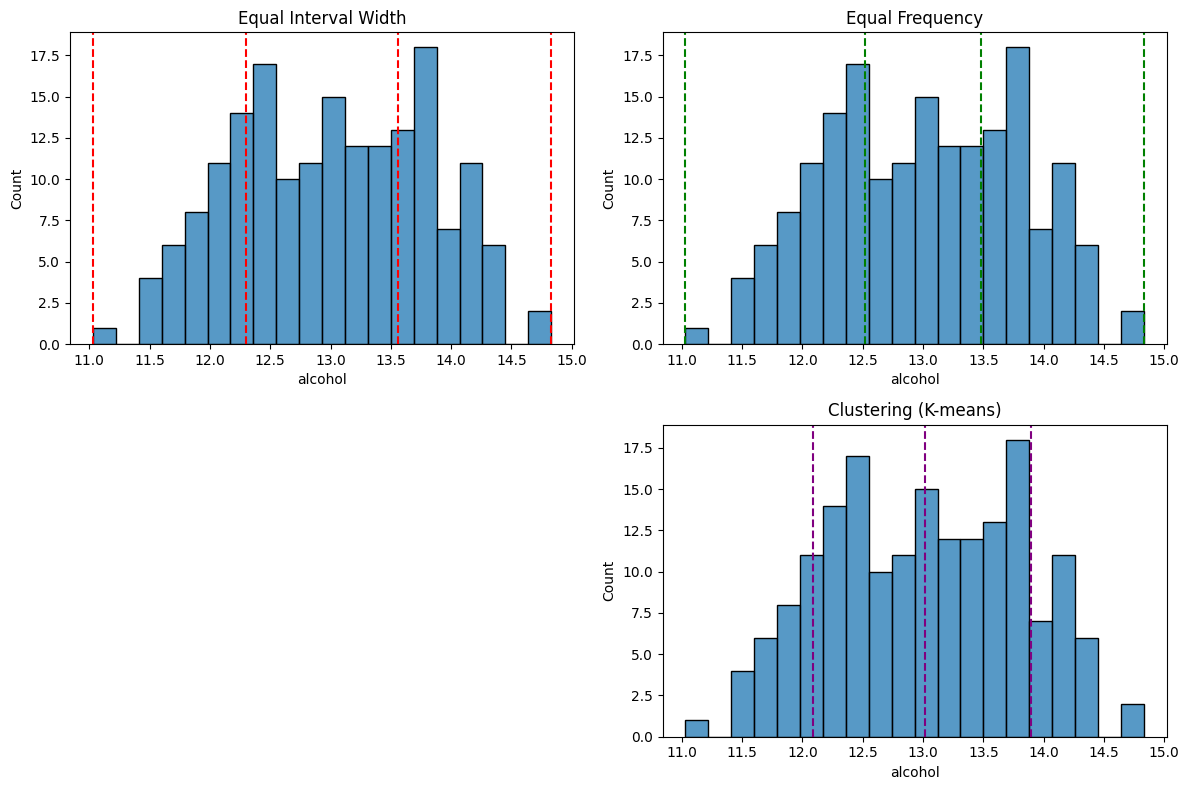

In [31]:
# Histogramme de la variable alcohol
plt.figure(figsize=(12,8))

# Méthode 1: Equal Width
plt.subplot(2,2,1)
sns.histplot(df['alcohol'], bins=20, kde=False)
for b in bins:   # <-- ici on utilise la liste bins calculée avant
    plt.axvline(b, color='red', linestyle='--')
plt.title("Equal Interval Width")

# Méthode 2: Equal Frequency
plt.subplot(2,2,2)
sns.histplot(df['alcohol'], bins=20, kde=False)
for b in equal_freq.bin_edges_[0]:
    plt.axvline(b, color='green', linestyle='--')
plt.title("Equal Frequency")

# Méthode 3: Entropy-based (si installé)
"""plt.subplot(2,2,3)
sns.histplot(df['alcohol'], bins=20, kde=False)
try:
    for b in entropy_disc.cut_points_[0]:
        plt.axvline(b, color='blue', linestyle='--')
    plt.title("Entropy-based")
except:
    plt.title("Entropy-based (non installé)")
"""
# Méthode 4: Clustering
plt.subplot(2,2,4)
sns.histplot(df['alcohol'], bins=20, kde=False)
centers = np.sort(kmeans.cluster_centers_.flatten())
for c in centers:
    plt.axvline(c, color='purple', linestyle='--')
plt.title("Clustering (K-means)")

plt.tight_layout()
plt.show()
